In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from graphite_maps.linear_regression import boost_linear_regression
from graphite_maps.linear_regression import linear_l1_regression

from sklearn.linear_model import LassoCV 

In [2]:
def standardize_data(X, y):
    scaler_X = StandardScaler().fit(X)
    X_scaled = scaler_X.transform(X)
    
    scaler_y = StandardScaler().fit(y.reshape(-1, 1))
    y_scaled = scaler_y.transform(y.reshape(-1, 1)).flatten()
    
    return X_scaled, y_scaled, scaler_X, scaler_y

# generate data
#np.random.seed(42)
n = 1000
p_noisy = 999
X1 = np.random.rand(n, 1)
X2 = np.random.rand(n, 1)
X3 = np.random.rand(n, 1)
X = np.hstack((X1, X2, X3))

In [3]:
y = 1 * X[:,0] - X[:,1] + X[:,2] + np.random.randn(n) * 1e-2  # True relationship with some noise

# Generate 9 additional noise features
noise_features = np.random.rand(n, p_noisy)  # 100 samples, 9 noise features

# Concatenate the noise features with the original feature
X_with_noise = np.hstack((X, noise_features))
#print(X_with_noise.shape)

# Standardize the expanded dataset (with noise features) and the target variable
X_with_noise_scaled, y_scaled, scaler_X, scaler_y = standardize_data(X_with_noise, y)

In [4]:
def cv_fit(y, U_scaled, kfolds=10):
    eps = 1e-3
    max_iter = 10000
    model_cv = LassoCV(
        cv=kfolds, fit_intercept=False, max_iter=max_iter, eps=eps
    )
    model_cv.fit(U_scaled, y)
    return model_cv.coef_

In [6]:
res = cv_fit(y=y_scaled, U_scaled=X_with_noise_scaled)
res

KeyboardInterrupt: 

# Time LASSO

In [7]:
from timeit import default_timer as timer

In [8]:
# Generate data
n = 100
X1 = np.random.rand(n, 1)
X2 = np.random.rand(n, 1)
X3 = np.random.rand(n, 1)
X = np.hstack((X1, X2, X3))

y = 1 * X[:,0] - X[:,1] + X[:,2] + np.random.randn(n) * 1e-2  # True relationship with some noise

# Values of p_noisy to test
p_noisy_values = [int(1e1), int(1e2), int(1e3), int(1e4), int(1e5)]
timing_results = []

for p_noisy in p_noisy_values:
    # Generate noise features
    print(p_noisy)
    noise_features = np.random.rand(n, p_noisy)
    
    # Concatenate the noise features with the original features
    X_with_noise = np.hstack((X, noise_features))
    
    # Standardize the expanded dataset (with noise features) and the target variable
    X_with_noise_scaled, y_scaled, scaler_X, scaler_y = standardize_data(X_with_noise, y)
    
    # Time the cv_fit function
    start_time = timer()
    cv_fit(y=y_scaled, U_scaled=X_with_noise_scaled)
    end_time = timer()
    
    elapsed_time = end_time - start_time
    timing_results.append(elapsed_time)
    print(f"p_noisy: {p_noisy}, time: {elapsed_time:.4f} seconds")


10
p_noisy: 10, time: 0.0801 seconds
100
p_noisy: 100, time: 57.2323 seconds
1000
p_noisy: 1000, time: 70.5059 seconds
10000
p_noisy: 10000, time: 75.3201 seconds
100000
p_noisy: 100000, time: 115.8153 seconds


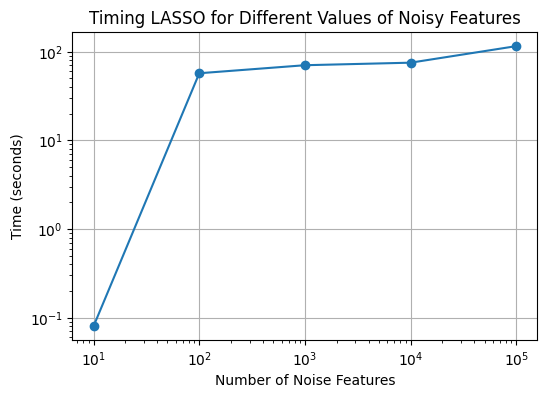

In [9]:
# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(p_noisy_values, timing_results, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Noise Features')
plt.ylabel('Time (seconds)')
plt.title('Timing LASSO for Different Values of Noisy Features')
plt.grid(True)
#plt.savefig('lasso_timing.png')
#if False is not None:
#    plt.savefig(f"lasso_timing.pdf", format='pdf', bbox_inches='tight')
plt.show()

# boost linreg informatin theoretic

In [10]:
# Generate data
n = 100
X1 = np.random.rand(n, 1)
X2 = np.random.rand(n, 1)
X3 = np.random.rand(n, 1)
X = np.hstack((X1, X2, X3))

y = 1 * X[:,0] - X[:,1] + X[:,2] + np.random.randn(n) * 1e-2  # True relationship with some noise

# Values of p_noisy to test
p_noisy_values = [int(1e1), int(1e2), int(1e3), int(1e4), int(1e5), int(1e6), int(1e7)]
timing_results_boost = []

for p_noisy in p_noisy_values:
    # Generate noise features
    print(p_noisy)
    noise_features = np.random.rand(n, p_noisy)
    
    # Concatenate the noise features with the original features
    X_with_noise = np.hstack((X, noise_features))
    
    # Standardize the expanded dataset (with noise features) and the target variable
    X_with_noise_scaled, y_scaled, scaler_X, scaler_y = standardize_data(X_with_noise, y)
    
    # Time the cv_fit function
    start_time = timer()
    boost_linear_regression(
        X = X_with_noise_scaled, 
        y = y_scaled, 
        learning_rate=0.1,
        max_iter=100
    )
    end_time = timer()
    
    elapsed_time = end_time - start_time
    timing_results_boost.append(elapsed_time)
    print(f"p_noisy: {p_noisy}, time: {elapsed_time:.4f} seconds")


10
p_noisy: 10, time: 0.0018 seconds
100
p_noisy: 100, time: 0.0313 seconds
1000
p_noisy: 1000, time: 1.6233 seconds
10000
p_noisy: 10000, time: 3.0115 seconds
100000
p_noisy: 100000, time: 3.3664 seconds
1000000
p_noisy: 1000000, time: 4.2719 seconds
10000000
p_noisy: 10000000, time: 21.2477 seconds


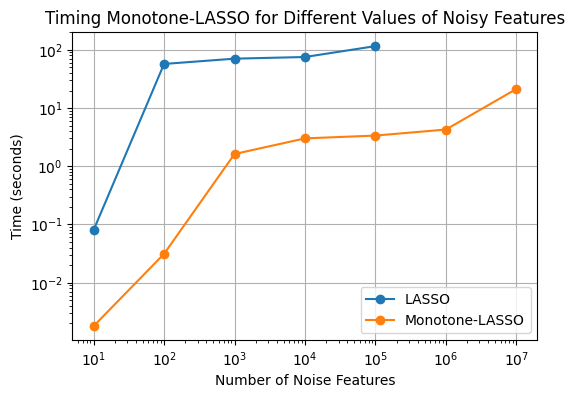

In [12]:
# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(p_noisy_values[:-2], timing_results, marker='o', label="LASSO")
plt.plot(p_noisy_values, timing_results_boost, marker='o', label="Monotone-LASSO")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Noise Features')
plt.ylabel('Time (seconds)')
plt.title('Timing Monotone-LASSO for Different Values of Noisy Features')
plt.legend()
plt.grid(True)
#plt.savefig('linreg_boost_timing.png')
if True is not None:
    plt.savefig(f"linreg_boost_timing.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [30]:
coefficients_with_noise_lr = linear_l1_regression(
    U = X_with_noise_scaled, 
    Y = y_scaled[:,np.newaxis], 
    verbose_level=1
).toarray().ravel()
coefficients_with_noise_lr

Learning sparse linear map of shape (1, 1002)


Learning sparse linear map for each response: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]

Total elements: 1002
Non-zero elements: 22
Fraction of non-zeros: 0.021956087824351298


array([ 0.5721957 , -0.58882174,  0.58284667, ...,  0.        ,
        0.        ,  0.        ])

# Check overfitting

### Self-implement regression

In [340]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import spmatrix
from scipy.stats import chi2
from scipy.integrate import quad
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm



def expected_max_chisq(p):
    """Expected maximum of p central chi-square(1) random variables."""

    def dmaxchisq(x):
        return 1.0 - np.exp(p * chi2.logcdf(x, df=1))

    expectation, _ = quad(dmaxchisq, 0, np.inf)
    return expectation


def mse(residuals):
    return 0.5 * np.mean(residuals**2)


def calculate_psi_M(x, y, beta_estimate):
    """The psi/score function for mse: 0.5*residual**2."""
    residuals = y - beta_estimate * x
    psi = -residuals * x
    M = -np.mean(x**2)
    return psi, M


def calculate_influence(x, y, beta_estimate):
    """The influence of (x, y) on beta_estimate as an mse M-estimator."""
    psi, M = calculate_psi_M(x, y, beta_estimate)
    return psi / M


def boost_linear_regression(
    X, y, learning_rate=0.5, tol=1e-6, max_iter=10000, effective_dimension=None, force_to_maxiter=True, X_te=None, y_te=None
):
    """Boost coefficients of linearly regressing y on standardized X.

    The coefficient selection utilizes information theoretic weighting. The
    stopping criterion utilizes information theoretic loss-reduction.
    """
    n_samples, n_features = X.shape
    coefficients = np.zeros(n_features)
    residuals = y.copy()
    residuals_loo = y.copy()
    residuals_te = y_te.copy()

    # A stricter criterion is the loo-adjustment: mse(residuals_loo)-mse
    # (residuals). This converges to TIC. Under certain conditions this is AIC.
    # At worst, we are maximizing squares. See Lunde 2020 Appendix A. This
    #  needs to be adjusted for.
    # The mse_factor adjusts for this.
    # if effective_dimension is None:
    #    effective_dimension = n_features
    # mse_factor = expected_max_chisq(np.ceil(effective_dimension))

    mse_tr, mse_te, mse_loo = np.zeros(max_iter), np.zeros(max_iter), np.zeros(max_iter)
    mse_tr[0] = mse(residuals)
    mse_te[0] = mse(residuals_te)
    mse_loo[0] = mse(residuals_loo)
    iter_stop = 0

    cutoff = 2.0 * learning_rate / np.sqrt(n_samples)  # 2.0: 95% ci-ish
    for i in range(1, max_iter):
        coef_changes = np.dot(X.T, residuals) / n_samples

        # Could be adjusted for IC -- some features already included
        # The IC would build in additional motivation for sparsity
        feature_evaluation = np.abs(coef_changes)

        # Select feature based on loss criterion
        best_feature = np.argmax(feature_evaluation)
        beta_estimate = coef_changes[best_feature]

        # adjust to loo estimates for coef_change
        influence = calculate_influence(
            X[:, best_feature], residuals, beta_estimate
        )
        beta_estimate_loo = beta_estimate - influence / n_samples

        # residuals_full = residuals - beta_estimate * X[:, best_feature]
        residuals_full_loo = (
            residuals_loo
            - learning_rate * beta_estimate_loo * X[:, best_feature]
        )

        if (mse(residuals_loo) < mse(residuals_full_loo)) and (iter_stop==0):
            iter_stop = i
            #break

        # Check if adding the full weight of the feature would decrease loss
        # if mse(residuals) < mse(residuals_full) + mse_factor * (
        #    mse(residuals_full_loo) - mse(residuals_full)
        # ):
        #    break

        coef_change = beta_estimate * learning_rate
        coef_change_loo = beta_estimate_loo * learning_rate

        # Check for convergence
        if (np.abs(coef_change) < tol) and (not force_to_maxiter):
            break
        else:
            # Update
            residuals -= coef_change * X[:, best_feature]
            coefficients[best_feature] += coef_change

            # loo update
            residuals_loo -= coef_change_loo * X[:, best_feature]

            # eval
            mse_tr[i] = mse(residuals)
            residuals_te -= coef_change * X_te[:,best_feature]
            mse_te[i] = mse(residuals_te)
            mse_loo[i] = mse(residuals_loo)

    # ensure cutoff values -- very small if data standardized
    # prefer sparsity
    cutoff = 2.0 * learning_rate / np.sqrt(n_samples)  # 2.0: 95% ci-ish
    coefficients[np.abs(coefficients) < cutoff] = 0

    return coefficients, mse_tr, mse_te, mse_loo, iter_stop

### Run with test data 

In [341]:
# Generate data
n = 100 * 2

# All data
X1 = np.random.rand(n, 1)
X2 = np.random.rand(n, 1)
X3 = np.random.rand(n, 1)
X_relevant = np.hstack((X1, X2, X3))

y = 1 * X_relevant[:,0] - X_relevant[:,1] + X_relevant[:,2] + np.random.randn(n) * 1e-2  # True relationship with some noise

p_noisy = int(1e3)
# Generate noise features
print(p_noisy)
noise_features = np.random.rand(n, p_noisy)
# Concatenate the noise features with the original features
X = np.hstack((X_relevant, noise_features))

# split
X_tr, X_te = X[:int(n/2),:], X[int(n/2):,:]
print(X_tr.shape, X_te.shape)
y_tr, y_te = y[:int(n/2)], y[int(n/2):]

# scale
X_tr_scaled, y_tr_scaled, scaler_X, scaler_y = standardize_data(X_tr, y_tr)
X_te_scaled = scaler_X.transform(X_te)
y_te_scaled = scaler_y.transform(y_te[:,np.newaxis]).flatten()

1000
(100, 1003) (100, 1003)


In [357]:
coefficients, mse_tr, mse_te, mse_loo, iter_stop = boost_linear_regression(
    X = X_tr_scaled, 
    y = y_tr_scaled, 
    learning_rate=0.5,
    max_iter=100,
    force_to_maxiter=True, 
    X_te=X_te_scaled,
    y_te=y_te_scaled
)

In [358]:
iter_stop

64

In [359]:
coefficients.nonzero()[0]

array([0, 1, 2])

In [363]:
coefficients[:3]

array([ 0.5648159 , -0.56826574,  0.53259687])

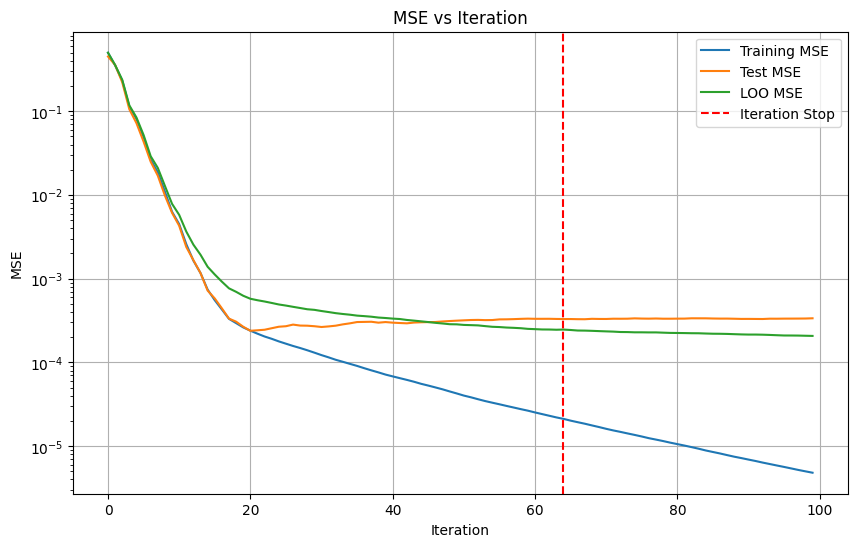

In [361]:
# Plot mse_tr and mse_te against their indexes
plt.figure(figsize=(10, 6))
plt.plot(mse_tr, label='Training MSE')
plt.plot(mse_te, label='Test MSE')
plt.plot(mse_loo, label='LOO MSE')

# Plot a vertical line at iter_stop
plt.axvline(x=iter_stop, color='r', linestyle='--', label='Iteration Stop')

# Adding labels and title
plt.yscale("log")
#plt.xscale("log")
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('MSE vs Iteration')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [243]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Generate data using scikit-learn's make_regression
def generate_data(n_samples, n_features, n_informative, noise=0.1):
    X, y = make_regression(n_samples=n_samples, n_features=n_features, 
                           n_informative=n_informative, noise=noise)
    return X, y

# Standardize the data
def standardize_data(X, y):
    scaler_X = StandardScaler().fit(X)
    X_scaled = scaler_X.transform(X)
    
    scaler_y = StandardScaler().fit(y.reshape(-1, 1))
    y_scaled = scaler_y.transform(y.reshape(-1, 1)).flatten()
    
    return X_scaled, y_scaled, scaler_X, scaler_y

# Generate training and test data
n_samples = 100
n_informative = 5
n_noisy = 1000

X, Y = generate_data(2*n_samples, n_informative + n_noisy, n_informative)
X_train, y

# Standardize the data
X_tr_scaled, y_tr_scaled, scaler_X, scaler_y = standardize_data(X_train, y_train)
X_te_scaled = scaler_X.transform(X_test)
y_te_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [252]:
coefficients, mse_tr, mse_te, mse_loo, iter_stop = boost_linear_regression(
    X = X_tr_scaled, 
    y = y_tr_scaled, 
    learning_rate=0.05,
    max_iter=100,
    force_to_maxiter=True, 
    X_te=X_te_scaled,
    y_te=y_te_scaled
)

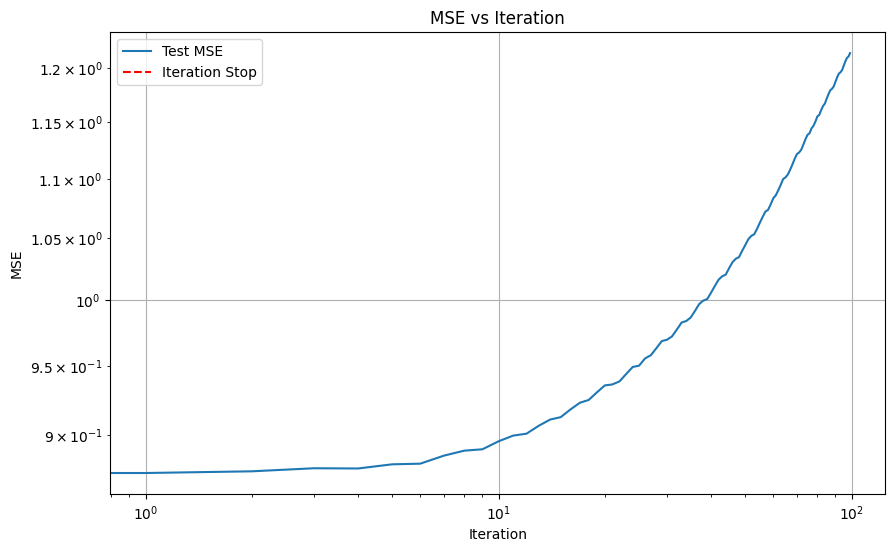

In [253]:
# Plot mse_tr and mse_te against their indexes
plt.figure(figsize=(10, 6))
#plt.plot(mse_tr, label='Training MSE')
plt.plot(mse_te, label='Test MSE')
#plt.plot(mse_loo, label='LOO MSE')

# Plot a vertical line at iter_stop
plt.axvline(x=iter_stop, color='r', linestyle='--', label='Iteration Stop')

# Adding labels and title
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('MSE vs Iteration')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

(3,)
(array([0, 1, 2]),)
[ 0.55598404 -0.57072184  0.56576963]


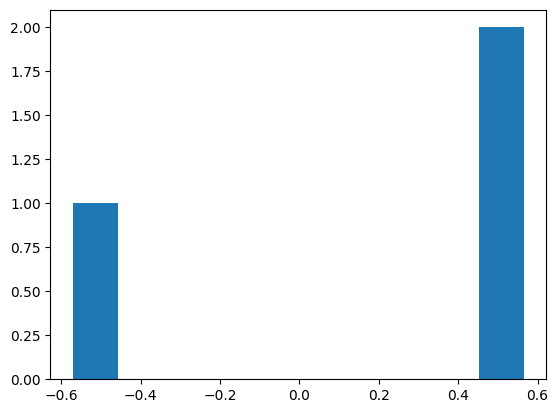

In [32]:
# Apply the updated function with learning rate to the standardized data with noise features
max_iter = 10000
coefficients_with_noise_lr = boost_linear_regression(
    X = X_with_noise_scaled, 
    y = y_scaled, 
    learning_rate=0.1,
    max_iter=100
)
#cutoff = 1e-2
#coefficients_with_noise_lr[np.abs(coefficients_with_noise_lr)<cutoff] = 0
print(coefficients_with_noise_lr.nonzero()[0].shape)
ind = coefficients_with_noise_lr.nonzero()
print(ind)
print(coefficients_with_noise_lr[ind])
plt.hist(coefficients_with_noise_lr[ind])
plt.show()

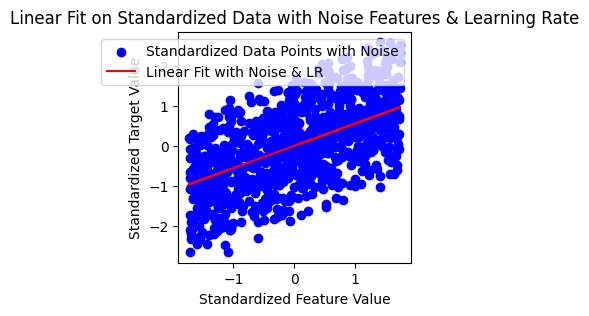

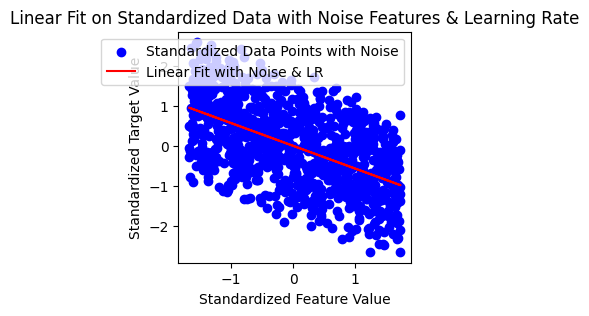

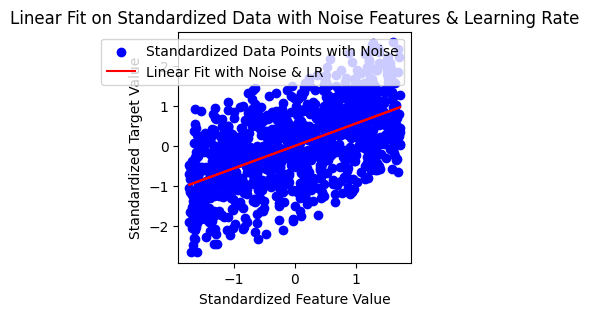

In [33]:
# Plot the original data and the linear fit with standardized coefficients, including noise features and learning rate
for ind in range(3):
    plt.figure(figsize=(3, 3))
    plt.scatter(X_with_noise_scaled[:, ind], y_scaled, color='blue', label='Standardized Data Points with Noise')
    plt.plot(X_with_noise_scaled[:, ind], np.dot(X_with_noise_scaled[:,ind], coefficients_with_noise_lr[ind]), color='red', label='Linear Fit with Noise & LR')
    plt.title('Linear Fit on Standardized Data with Noise Features & Learning Rate')
    plt.xlabel('Standardized Feature Value')
    plt.ylabel('Standardized Target Value')
    plt.legend()
    plt.show()

In [28]:
coefficients_with_noise_lr.shape

(1002,)